# Regression analysis



In [16]:
import xarray as xr
import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools
from matplotlib import pyplot as plt
import glob
import scipy
from modules import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preprocessing

We want to apply the following to the data:

    1) Find the anomalies
    2) Get the annual average
    3) Normalise the indepenant variables

In [17]:
files = glob.glob('processed_data/*')
files = [f for f in files if '_' not in f.split('\\')[1]]
ds = xr.open_mfdataset(files, parallel=True)

In [18]:
ds

<xarray.Dataset>
Dimensions:  (time: 503, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1978-11-01 1978-12-01 ... 2020-09-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    si10     (time, y, x) float64 dask.array<chunksize=(503, 332, 316), meta=np.ndarray>
    sic      (time, y, x) float64 dask.array<chunksize=(503, 332, 316), meta=np.ndarray>
    skt      (time, y, x) float64 dask.array<chunksize=(503, 332, 316), meta=np.ndarray>
    sp       (time, y, x) float64 dask.array<chunksize=(503, 332, 316), meta=np.ndarray>
    ssr      (time, y, x) float64 dask.array<chunksize=(503, 332, 316), meta=np.ndarray>
    ssrd     (time, y, x) float64 dask.array<chunksize=(503, 332, 316), meta=np.ndarray>
    sst      (time, y, x) float64 dask.array<chunksize=(503, 332, 316), meta=np.ndarray>
    t2m      (time, y, x) float64 dask.array<chunksize=(503, 332, 316), meta=np.ndarray>
    u10      (time, y, x) float64 dask.array<chunksize=(503, 332, 316), meta=np.ndarray>
    v10      (time, y, x) float64 dask.array<chunksize=(503, 332, 316), meta=np.ndarray>

In [19]:
ds = ds.sel(time=slice('1979-01-01','2019-12-31'))
ds = (ds
      .pipe(w5.find_anomalies)
      .pipe(w5.yearly_average)
      .pipe(w5.normalise_indepenant, dependant='sic')
     ).compute()

C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib

In [20]:
ds

<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    si10     (time, y, x) float64 0.0 0.0 0.0 0.0 ... 2.143 2.125 2.098 2.051
    sic      (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    skt      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -1.308 -1.336 -1.453
    sp       (time, y, x) float64 0.0 0.0 0.0 0.0 ... 0.02608 0.0623 0.099
    ssr      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -0.4578 -0.4181 -0.3338
    ssrd     (time, y, x) float64 0.0 0.0 0.0 0.0 ... -0.4388 -0.401 -0.3189
    sst      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -1.311 -1.339 -1.457
    t2m      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -1.503 -1.526 -1.576
    u10      (time, y, x) float64 0.0 0.0 0.0 0.0 ... 2.552 2.545 2.536 2.521
    v10      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -0.5608 -0.5554 -0.5538

# Correlations

In [21]:
v = [v for v in ds]
correlation_matrix = pd.DataFrame(index=v,columns=v, dtype=np.float64)
for v1,v2 in tqdm(list(itertools.product(v,v))):
    vec1 = ds[v1].mean(dim=('x','y'))
    vec2 = ds[v2].mean(dim=('x','y'))
    correlation_matrix.loc[v1,v2]=xr.corr(vec1,vec2).values
    
def significant_bold(val, sig_level=0.9):
    bold = 'bold' if val > sig_level or val < -sig_level else ''
    return 'font-weight: %s' % bold
correlation_matrix.style.applymap(significant_bold,sig_level=0.9)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.64it/s]


,si10,sic,skt,sp,ssr,ssrd,sst,t2m,u10,v10
si10,1.000000,0.193010,-0.288634,-0.633299,0.267617,0.261235,-0.215486,-0.194827,0.812793,-0.687884
sic,0.193010,1.000000,-0.711762,-0.042341,0.012555,0.516434,-0.686655,-0.717692,0.140194,-0.065320
skt,-0.288634,-0.711762,1.000000,0.252163,-0.030236,-0.408460,0.872786,0.985089,-0.380605,0.219702
sp,-0.633299,-0.042341,0.252163,1.000000,0.005248,0.040735,0.024328,0.201595,-0.828970,0.549023
ssr,0.267617,0.012555,-0.030236,0.005248,1.000000,0.800952,-0.012657,-0.031298,0.038856,0.029796
ssrd,0.261235,0.516434,-0.408460,0.040735,0.800952,1.000000,-0.416684,-0.407482,0.012757,0.031371
sst,-0.215486,-0.686655,0.872786,0.024328,-0.012657,-0.416684,1.000000,0.822488,-0.149241,0.094133
t2m,-0.194827,-0.717692,0.985089,0.201595,-0.031298,-0.407482,0.822488,1.000000,-0.320275,0.136325
u10,0.812793,0.140194,-0.380605,-0.828970,0.038856,0.012757,-0.149241,-0.320275,1.000000,-0.796108
v10,-0.687884,-0.065320,0.219702,0.549023,0.029796,0.031371,0.094133,0.136325,-0.796108,1.000000


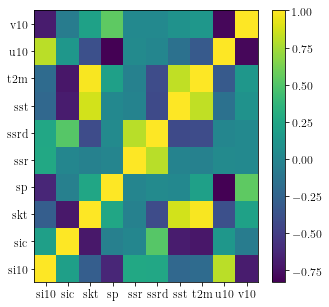

In [22]:
fig = plt.figure(figsize=(5,5))
plt.pcolormesh(correlation_matrix)
plt.colorbar()
plt.xticks(np.arange(0,len(v))+0.5,v)
plt.yticks(np.arange(0,len(v))+0.5,v)
plt.savefig('images/week5/correlations.pdf')
plt.show()

# Regressions

In [23]:
x_surface = ['si10','sp', 'ssr', 'sst','t2m','u10','v10']

regression_results = w4.multiple_fast_regression(ds, 'sic', x_surface)

Finding coefficients for ['si10', 'sp', 'ssr', 'sst', 't2m', 'u10', 'v10'] against sic


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:13<00:00, 7791.43it/s]


Predicting SIC


In [24]:
regression_results

<xarray.Dataset>
Dimensions:                                 (time: 41, x: 316, y: 332)
Coordinates:
  * time                                    (time) datetime64[ns] 1979-01-01 ...
  * y                                       (y) int32 4350000 ... -3925000
  * x                                       (x) int32 -3950000 ... 3925000
Data variables:
    sic                                     (x, y, time) float64 0.0 0.0 ... 0.0
    si10                                    (x, y, time) float64 0.0 ... 2.051
    sp                                      (x, y, time) float64 0.0 ... 0.099
    ssr                                     (x, y, time) float64 0.0 ... -0.3338
    sst                                     (x, y, time) float64 0.0 ... -1.457
    t2m                                     (x, y, time) float64 0.0 ... -1.576
    u10                                     (x, y, time) float64 0.0 ... 2.521
    v10                                     (x, y, time) float64 0.0 ... -0.5538
    prediction_si10_sp_ssr_sst_t2m_u10_v10  (x, y, time) float64 0.0 0.0 ... 0.0
    regr_coef_si10                          (x, y) float64 0.0 0.0 ... 0.0 0.0
    regr_coef_sp                            (x, y) float64 0.0 0.0 ... 0.0 0.0
    regr_coef_ssr                           (x, y) float64 0.0 0.0 ... 0.0 0.0
    regr_coef_sst                           (x, y) float64 0.0 0.0 ... 0.0 0.0
    regr_coef_t2m                           (x, y) float64 0.0 0.0 ... 0.0 0.0
    regr_coef_u10                           (x, y) float64 0.0 0.0 ... 0.0 0.0
    regr_coef_v10                           (x, y) float64 0.0 0.0 ... 0.0 0.0
    regr_coef_error                         (x, y) float64 0.0 0.0 ... 0.0 0.0
    prediction_si10                         (x, y, time) float64 0.0 0.0 ... 0.0
    prediction_sp                           (x, y, time) float64 0.0 0.0 ... 0.0
    prediction_ssr                          (x, y, time) float64 0.0 0.0 ... 0.0
    prediction_sst                          (x, y, time) float64 0.0 0.0 ... 0.0
    prediction_t2m                          (x, y, time) float64 0.0 0.0 ... 0.0
    prediction_u10                          (x, y, time) float64 0.0 0.0 ... 0.0
    prediction_v10                          (x, y, time) float64 0.0 0.0 ... 0.0

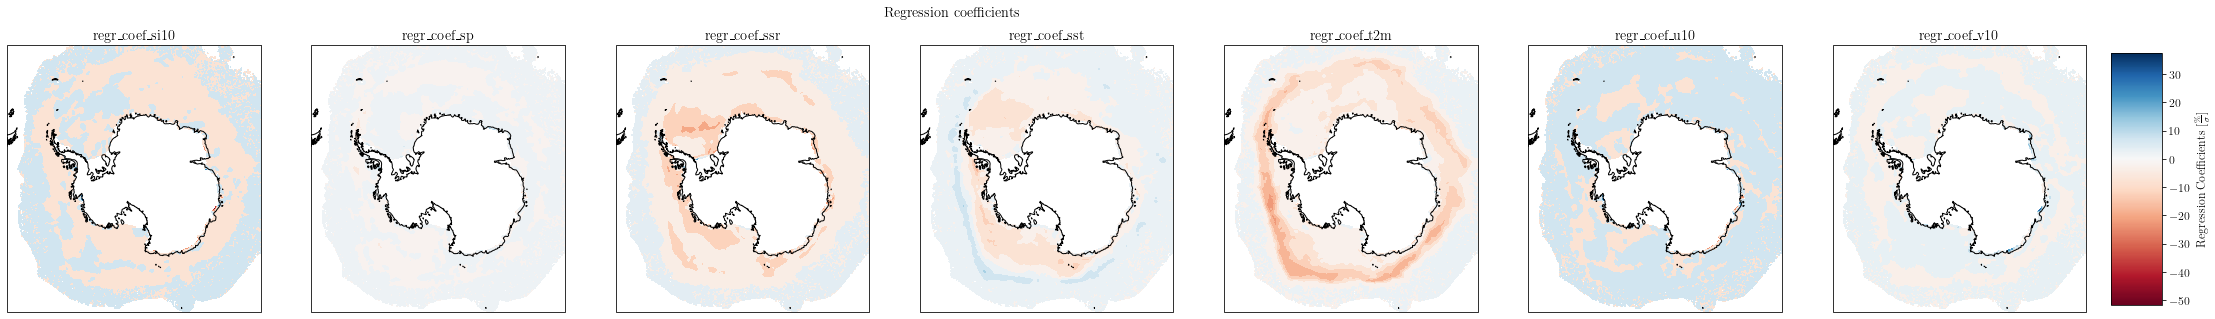

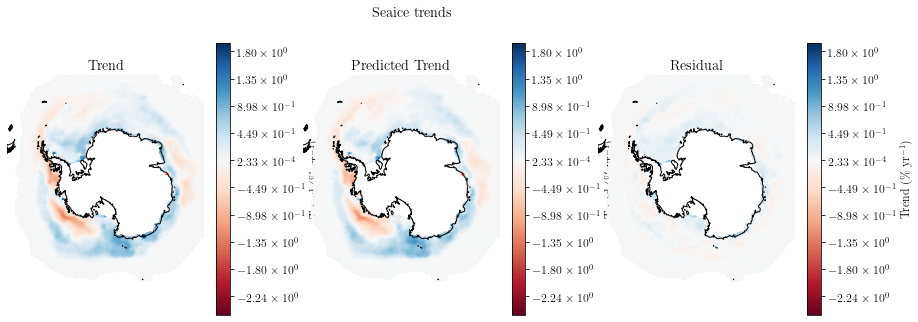

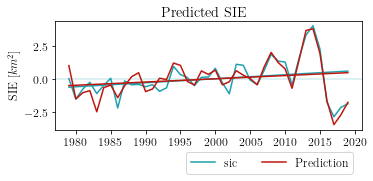

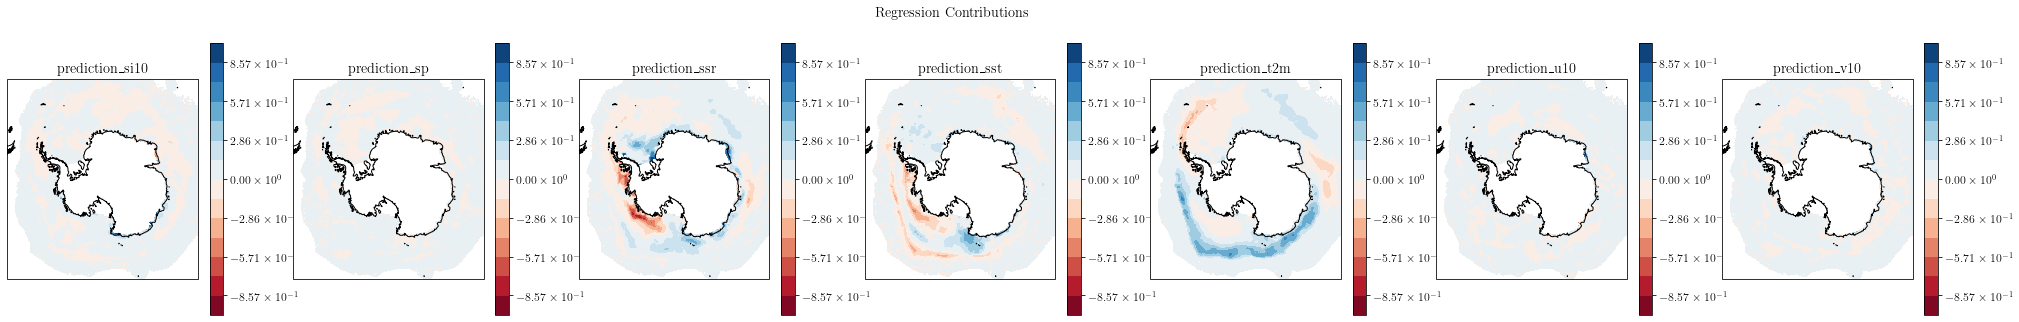

In [25]:
w5.plotting(regression_results, 'sic', x_surface)

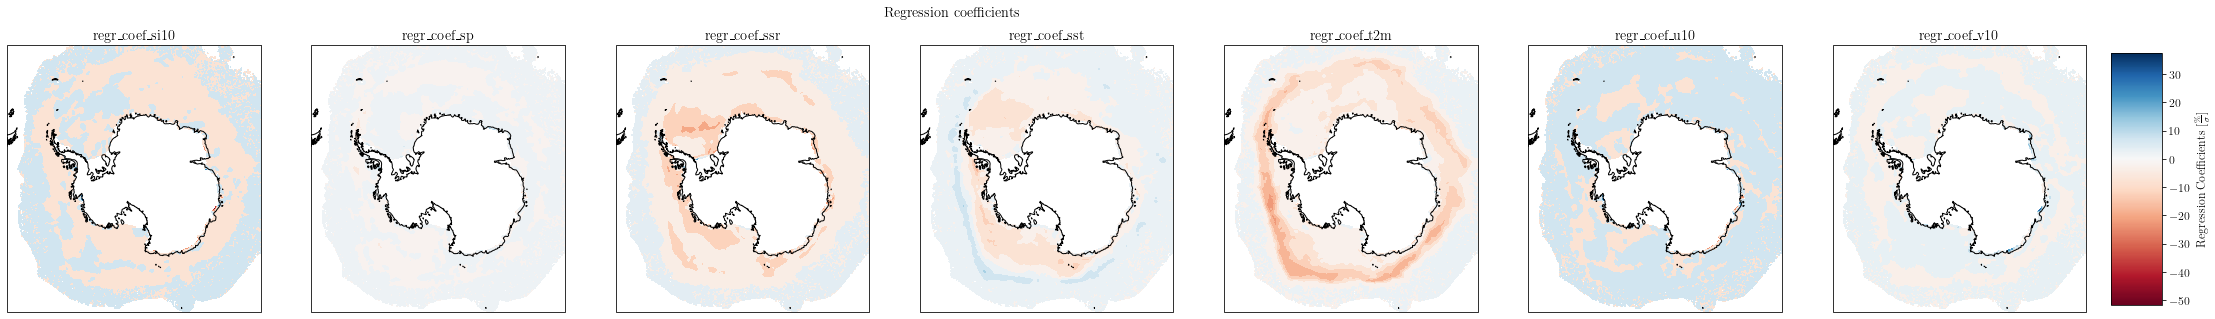

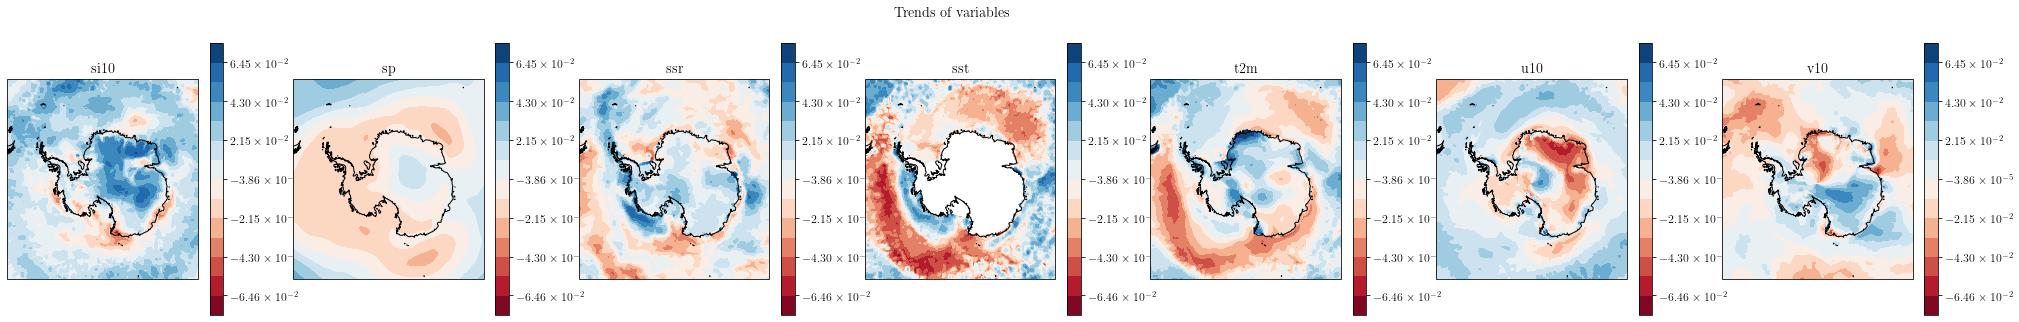

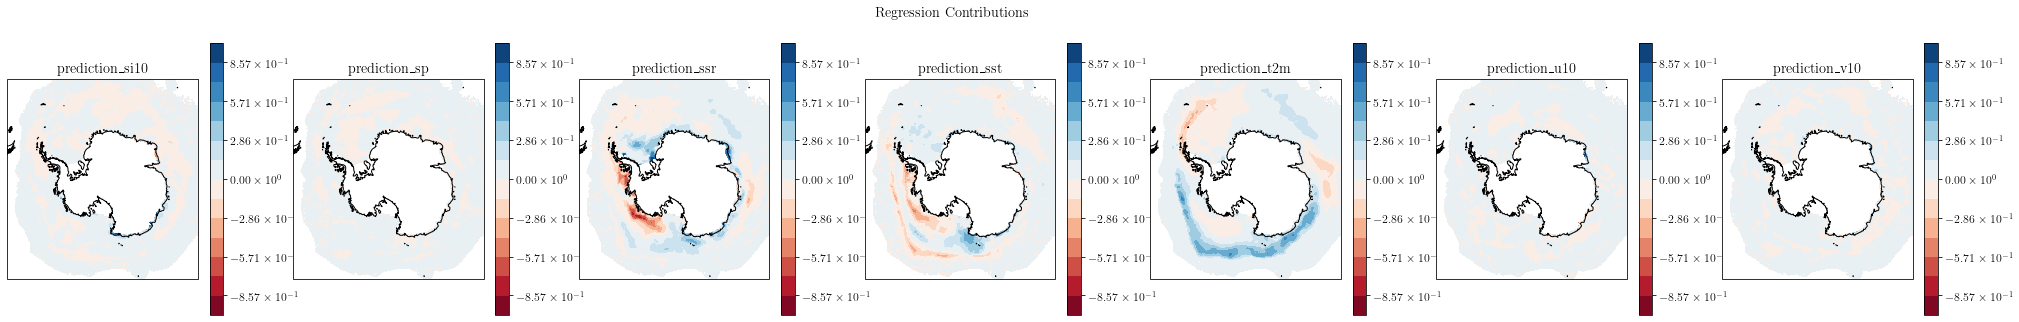

In [26]:
w5.more_plotting(regression_results, 'sic', x_surface)

In [27]:
stats = w4._get_stats(regression_results, 'sic' ,x_surface)
stats.name = 'Quality of Regression'
stats.index = [col.replace('_', ' ').capitalize() for col in stats.index]
stats.to_latex('..\Environmental-Impact-On-Sea-Ice\\index_stats_0.tex',  escape=False, column_format='l'*(len(stats.index)+1))

In [28]:
results = w4.indicies_stats(ds, regression_results, 'sic', x_surface,'SouthPolarStereo', 'annual','anomalous','raw')
results = results.sort_values('individual_Predicted_Trend', ascending=False)
results.columns = [col.replace('_', ' ').capitalize() for col in results.columns]
results.transpose().to_latex('..\Environmental-Impact-On-Sea-Ice\\index_stats_1.tex',  escape=False, column_format='l'*(len(results.index)+1))
results.transpose()

Finding coefficients for ['si10'] against sic


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:07<00:00, 13186.79it/s]


Predicting SIC
Finding coefficients for ['sp'] against sic


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:07<00:00, 13280.51it/s]


Predicting SIC
Finding coefficients for ['ssr'] against sic


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:07<00:00, 13148.19it/s]


Predicting SIC
Finding coefficients for ['sst'] against sic


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:07<00:00, 13550.10it/s]


Predicting SIC
Finding coefficients for ['t2m'] against sic


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:07<00:00, 13183.01it/s]


Predicting SIC
Finding coefficients for ['u10'] against sic


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:08<00:00, 13098.65it/s]


Predicting SIC
Finding coefficients for ['v10'] against sic


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:07<00:00, 13195.49it/s]


Predicting SIC


,sst,t2m,sp,ssr,u10,v10,si10
Individual spatial correlation,0.751019,0.689585,0.170964,0.887847,0.325601,0.335937,0.438060
Individual temporal correlation,0.771382,0.872630,0.186088,0.586862,0.236975,0.034008,0.122143
Individual actual trend,0.030381,0.030381,0.030381,0.030381,0.030381,0.030381,0.030381
Individual predicted trend,0.030662,0.028956,0.006140,0.002219,0.001553,0.000451,-0.008349
Spatial correlation,0.538685,0.561696,-0.058095,0.846708,0.028868,-0.101038,0.247904
Temporal correlation,0.651917,0.867692,0.098228,0.619701,0.022186,0.147109,-0.034022
Actual trend,0.030381,0.030381,0.030381,0.030381,0.030381,0.030381,0.030381
Predicted trend,-0.003692,0.023728,0.001424,0.001382,0.002860,0.001302,-0.002524


C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 42 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\dask\array\numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    IPO      (time, x, y) float64 0.306 0.306 0.306 ... -0.1306 -0.1306 -0.1306
    nina34   (time, x, y) float64 -0.002797 -0.002797 ... 0.8255 0.8255
    nina12   (time, x, y) float64 0.003394 0.003394 0.003394 ... -0.1185 -0.1185
    DMI      (time, x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 2.61 2.61 2.61 2.61
    SAM      (time, x, y) float64 0.4916 0.4916 0.4916 ... -1.262 -1.262 -1.262
    meiv2    (time, x, y) float64 0.3589 0.3589 0.3589 ... 0.4868 0.4868 0.4868
    SOI      (time, x, y) float64 0.2005 0.2005 0.2005 ... -0.8918 -0.8918
    t2m      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -0.367 -0.3723 -0.3834
Finding coefficients for ['IPO', 'nina34', 'nina12', 'DMI', 'SA

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:11<00:00, 8911.15it/s]


Predicting SIC


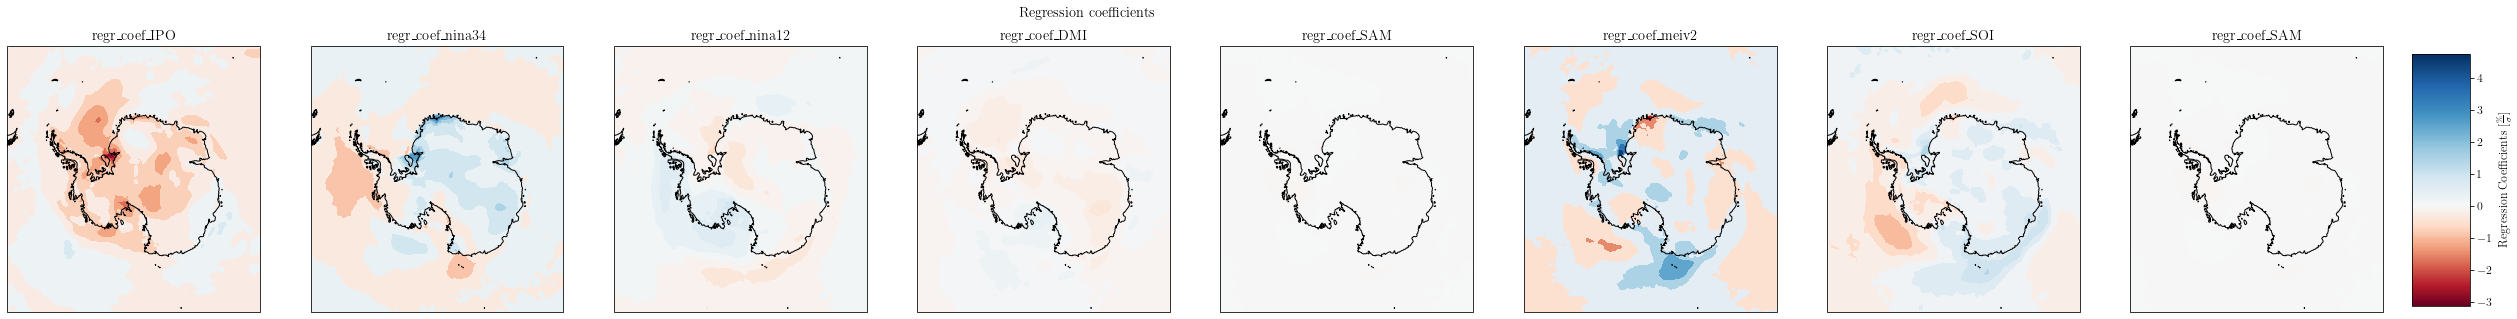

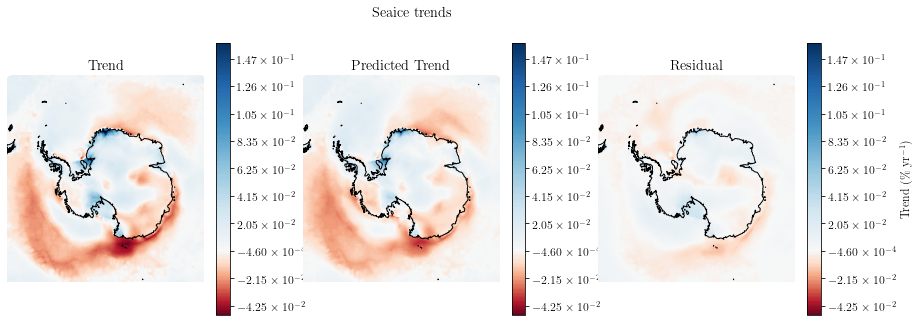

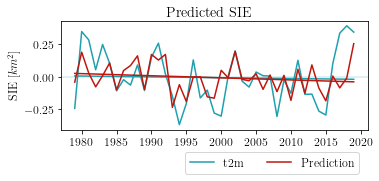

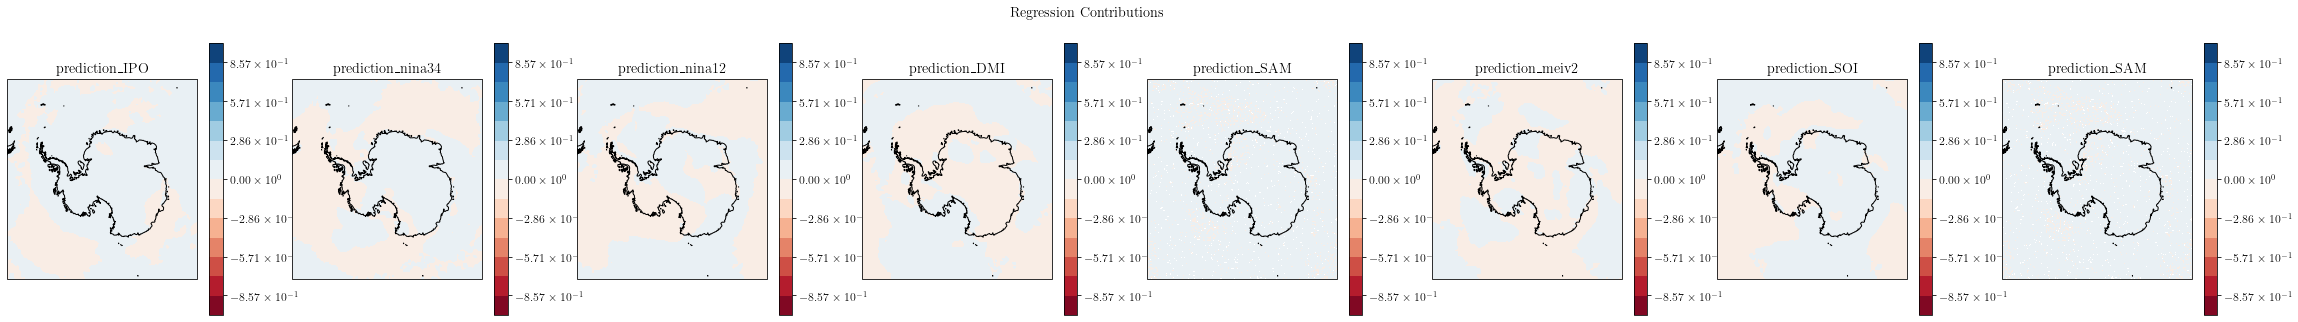

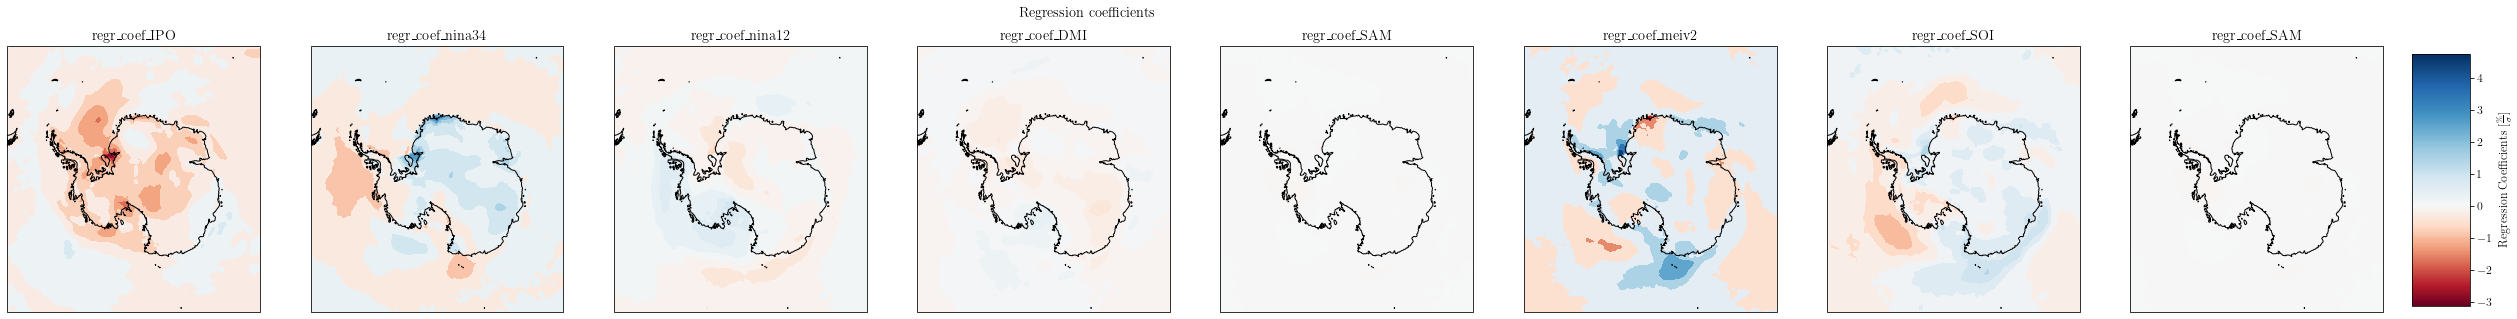

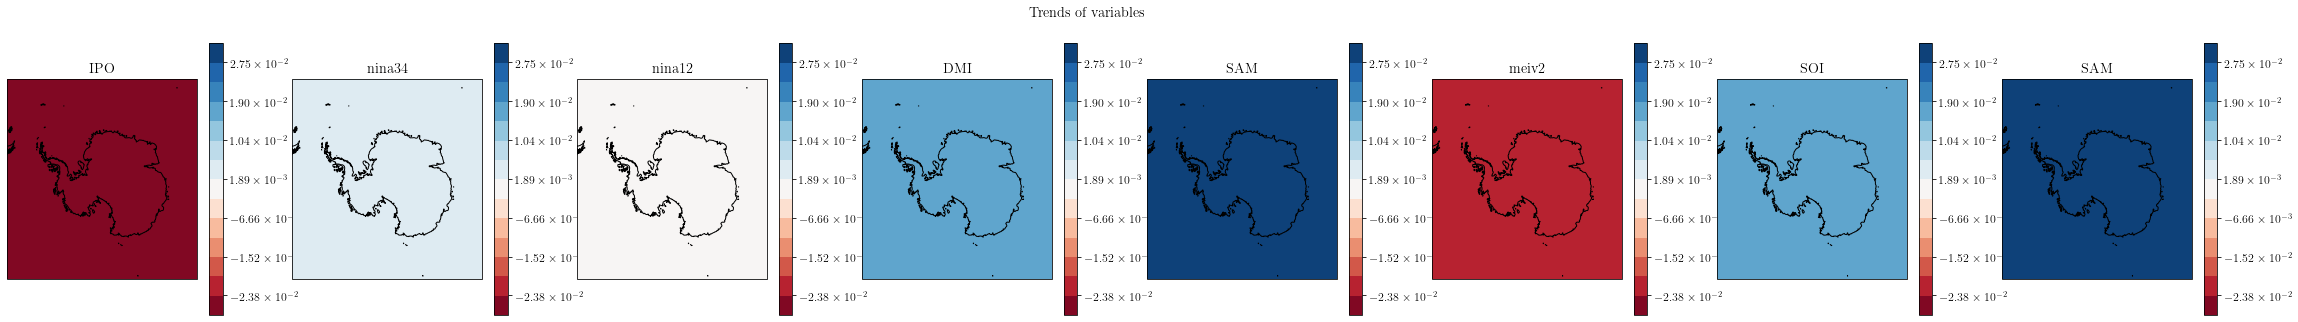

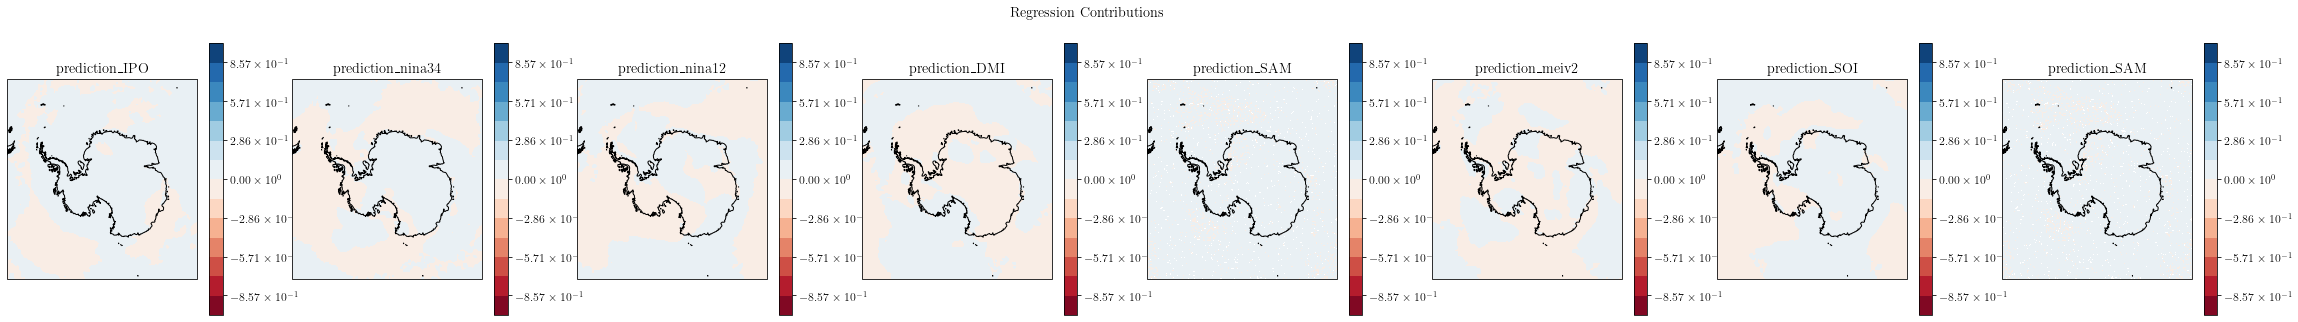

In [29]:
dependant = 't2m'
independant = ['IPO','nina34','nina12','DMI','SAM','meiv2','SOI','SAM']
files = glob.glob('processed_data/*')
files = [f for f in files if '_' not in f.split('\\')[1]]
ds = xr.open_mfdataset(files)

indicies_to_load = ['IPO','nina34','nina12','DMI','SAM','meiv2','SOI','SAM']
indicies = w5.load_indicies(indicies_to_load)
for ind in indicies:
    ds[ind] = indicies[ind]

ds = ds[independant + [dependant]]

# Preprocess the data
ds = (ds
      .pipe(w5.find_anomalies)
      .pipe(w5.yearly_average)
      .pipe(w5.normalise_indepenant, dependant=dependant)
     ).compute()

ds = ds.sel(time=slice('1979-01-01','2019-12-31'))
print(ds)

regression_results = w4.multiple_fast_regression(ds, dependant, independant)
w5.plotting(regression_results, dependant, independant)
w5.more_plotting(regression_results, dependant, independant)

C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 42 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 42 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 42 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 42 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib

<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    t2m      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -1.457 -1.485 -1.541
    sst      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -1.197 -1.23 -1.271 -1.403
    ssr      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -0.446 -0.3994 -0.3095
    sic      (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Finding coefficients for ['t2m', 'sst', 'ssr'] against sic


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:08<00:00, 11861.83it/s]


Predicting SIC


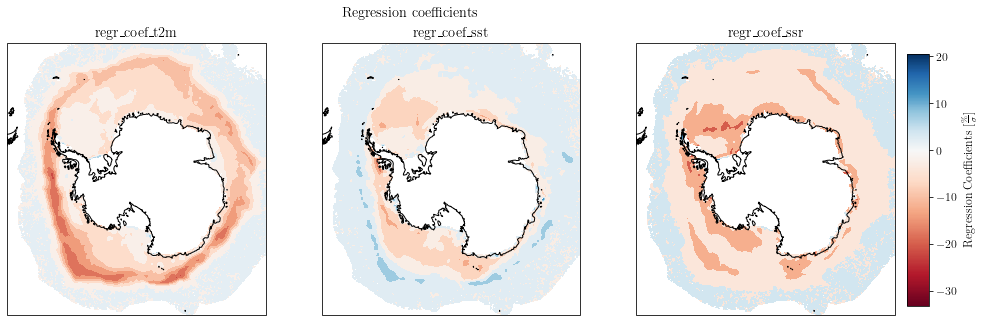

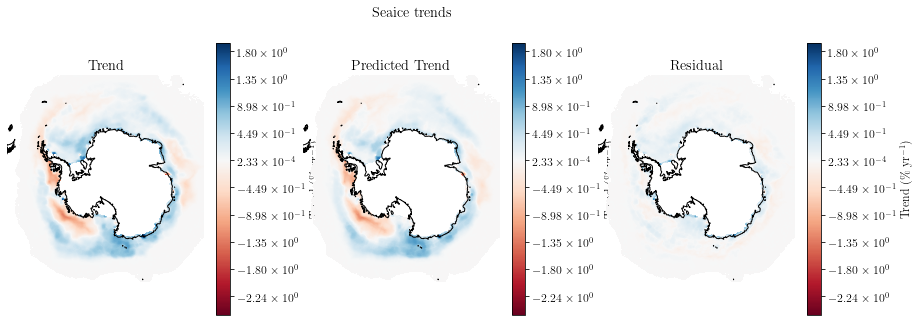

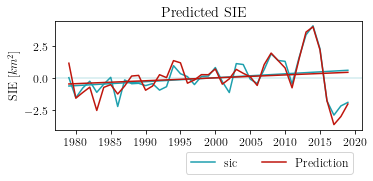

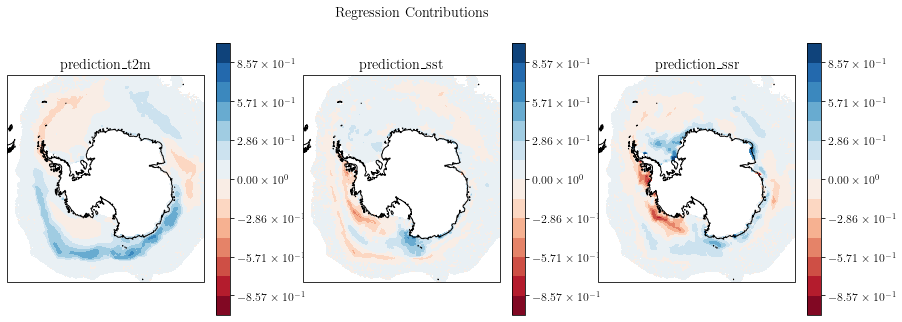

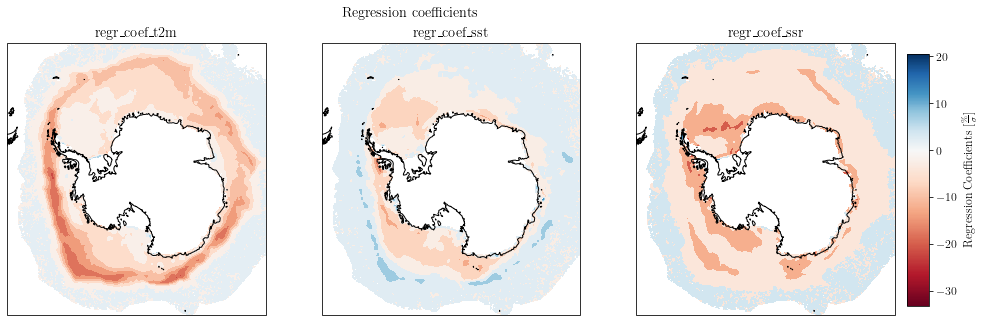

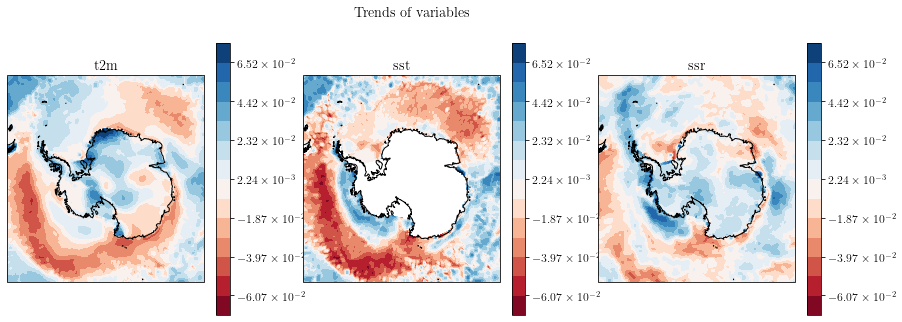

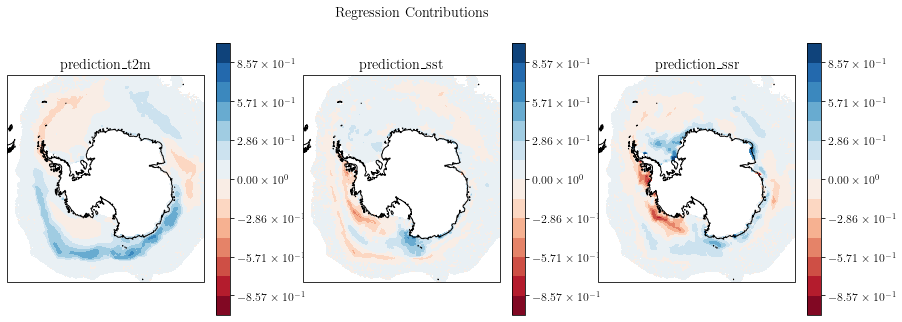

In [30]:
dependant = 'sic'
independant = ['t2m','sst','ssr']
files = glob.glob('processed_data/*')
files = [f for f in files if '_' not in f.split('\\')[1]]
ds = xr.open_mfdataset(files)

ds = ds[independant + [dependant]]

# Preprocess the data
ds = (ds
      .pipe(w5.find_anomalies)
      .pipe(w5.yearly_average)
      .pipe(w5.normalise_indepenant, dependant=dependant)
     ).compute()

ds = ds.sel(time=slice('1979-01-01','2019-12-31'))
print(ds)

regression_results = w4.multiple_fast_regression(ds, dependant, independant)
w5.plotting(regression_results, dependant, independant)
w5.more_plotting(regression_results, dependant, independant)

In [31]:
dependant = 'sst'
independant = ['IPO','nina34','nina12','DMI','SAM','meiv2','SOI','SAM']
files = glob.glob('processed_data/*')
files = [f for f in files if '_' not in f.split('\\')[1]]
ds = xr.open_mfdataset(files)

indicies_to_load = ['IPO','nina34','nina12','DMI','SAM','meiv2','SOI','SAM']
indicies = w5.load_indicies(indicies_to_load)
for ind in indicies:
    ds[ind] = indicies[ind]

ds = ds[independant + [dependant]]

# Preprocess the data
ds = (ds
      .pipe(w5.find_anomalies)
      .pipe(w5.yearly_average)
      .pipe(w5.normalise_indepenant, dependant=dependant)
     ).compute()

ds = ds.sel(time=slice('1979-01-01','2019-12-31'))
print(ds)

regression_results = w4.multiple_fast_regression(ds, dependant, independant)
w5.plotting(regression_results, dependant, independant)
w5.more_plotting(regression_results, dependant, independant)

C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 42 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\dask\array\numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    IPO      (time, x, y) float64 0.306 0.306 0.306 ... -0.1306 -0.1306 -0.1306
    nina34   (time, x, y) float64 -0.002797 -0.002797 ... 0.8255 0.8255
    nina12   (time, x, y) float64 0.003394 0.003394 0.003394 ... -0.1185 -0.1185
    DMI      (time, x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 2.61 2.61 2.61 2.61
    SAM      (time, x, y) float64 0.4916 0.4916 0.4916 ... -1.262 -1.262 -1.262
    meiv2    (time, x, y) float64 0.3589 0.3589 0.3589 ... 0.4868 0.4868 0.4868
    SOI      (time, x, y) float64 0.2005 0.2005 0.2005 ... -0.8918 -0.8918
    sst      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -0.4129 -0.4279 -0.4679
Finding coefficients for ['IPO', 'nina34', 'nina12', 'DMI', 'S

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:03<00:00, 28581.24it/s]


Predicting SIC


SystemExit: min = 0.0, max = 0.0, ['regr_coef_IPO', 'regr_coef_nina34', 'regr_coef_nina12', 'regr_coef_DMI', 'regr_coef_SAM', 'regr_coef_meiv2', 'regr_coef_SOI', 'regr_coef_SAM']

C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\IPython\core\interactiveshell.py:3425: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


<Figure size 2880x360 with 0 Axes>

In [ ]:
dependant = 'ssr'
independant = ['IPO','nina34','nina12','DMI','SAM','meiv2','SOI','SAM']
files = glob.glob('processed_data/*')
files = [f for f in files if '_' not in f.split('\\')[1]]
ds = xr.open_mfdataset(files)

indicies_to_load = ['IPO','nina34','nina12','DMI','SAM','meiv2','SOI','SAM']
indicies = w5.load_indicies(indicies_to_load)
for ind in indicies:
    ds[ind] = indicies[ind]

ds = ds[independant + [dependant]]

# Preprocess the data
ds = (ds
      .pipe(w5.find_anomalies)
      .pipe(w5.yearly_average)
      .pipe(w5.normalise_indepenant, dependant=dependant)
     ).compute()

ds = ds.sel(time=slice('1979-01-01','2019-12-31'))
print(ds)

regression_results = w4.multiple_fast_regression(ds, dependant, independant)
print(regression_results)
w5.plotting(regression_results, dependant, independant)
w5.more_plotting(regression_results, dependant, independant)

# Indicies

In [5]:
indicies_to_load = ['SAM', 'IPO']
# indicies = p2.load_indicies(indicies_to_load, 'monthly')

In [8]:
w5.load_indicies(indicies_to_load)

<xarray.Dataset>
Dimensions:  (time: 494, x: 316, y: 332)
Coordinates:
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-02-01
Data variables:
    SAM      (x, y, time) float64 0.74 -0.9 1.51 -0.49 ... -4.42 -1.78 nan nan
    IPO      (x, y, time) float64 -0.021 -0.273 -0.191 ... -0.083 -0.133 -0.293